# Сравнение моделей ResNet и EfficientNet

Этот notebook содержит эксперименты по обучению и сравнению двух архитектур моделей с различными гиперпараметрами для классификации изображений коров, броненосцев и черепах.


## 1. Импорты и настройка


In [25]:
import sys
import os
from pathlib import Path
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Добавляем путь к проекту
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Импорты из проекта
from fine_tune.config import Config, MODELS_DIR, FIGURES_DIR, set_seed
from fine_tune.modeling.train import Trainer
from fine_tune.modeling.models import create_model

# Настройка matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"Проект: {project_root}")
print(f"Модели: {MODELS_DIR}")
print(f"Графики: {FIGURES_DIR}")

# Устанавливаем seed для воспроизводимости
set_seed(42)


Проект: /Users/konopsky/University/AI_new/fine_tune
Модели: /Users/konopsky/University/AI_new/fine_tune/models
Графики: /Users/konopsky/University/AI_new/fine_tune/reports/figures


## 2. Определение экспериментов


In [30]:
# Определяем наборы гиперпараметров для экспериментов
experiments = {
    "baseline": {
        "epochs": 5,
        "learning_rate": 0.001,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "freeze_backbone": True
    },
    "high_lr": {
        "epochs": 5,
        "learning_rate": 0.01,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "freeze_backbone": True
    },
    "low_lr": {
        "epochs": 8,
        "learning_rate": 0.0001,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "freeze_backbone": True
    },
    "sgd_optimizer": {
        "epochs": 5,
        "learning_rate": 0.01,
        "optimizer": "sgd",
        "scheduler": "step",
        "freeze_backbone": True
    },
    "step_scheduler": {
        "epochs": 8,
        "learning_rate": 0.001,
        "optimizer": "adamw",
        "scheduler": "step",
        "freeze_backbone": True
    },
    "unfrozen_backbone": {
        "epochs": 5,
        "learning_rate": 0.0001,  # Меньший LR для размороженного backbone
        "optimizer": "adamw",
        "scheduler": "cosine",
        "freeze_backbone": False
    },
    "high_weight_decay": {
        "epochs": 5,
        "learning_rate": 0.001,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "freeze_backbone": True
    }
}

# Модели для сравнения (используем модели из конфигурации)
models = ["resnet50.a1_in1k", "efficientnet_b0.ra_in1k"]

print(f"Количество экспериментов: {len(experiments)}")
print(f"Модели: {models}")
print(f"Общее количество запусков: {len(experiments) * len(models)}")

# Показываем детали экспериментов
print("\nДетали экспериментов:")
for exp_name, exp_config in experiments.items():
    print(f"  {exp_name}: LR={exp_config['learning_rate']}, "
          f"Epochs={exp_config['epochs']}, "
          f"Optimizer={exp_config['optimizer']}, "
          f"Frozen={exp_config['freeze_backbone']}")


Количество экспериментов: 7
Модели: ['resnet50.a1_in1k', 'efficientnet_b0.ra_in1k']
Общее количество запусков: 14

Детали экспериментов:
  baseline: LR=0.001, Epochs=5, Optimizer=adamw, Frozen=True
  high_lr: LR=0.01, Epochs=5, Optimizer=adamw, Frozen=True
  low_lr: LR=0.0001, Epochs=8, Optimizer=adamw, Frozen=True
  sgd_optimizer: LR=0.01, Epochs=5, Optimizer=sgd, Frozen=True
  step_scheduler: LR=0.001, Epochs=8, Optimizer=adamw, Frozen=True
  unfrozen_backbone: LR=0.0001, Epochs=5, Optimizer=adamw, Frozen=False
  high_weight_decay: LR=0.001, Epochs=5, Optimizer=adamw, Frozen=True


## 3. Функция для запуска одного эксперимента


In [27]:
def run_experiment(model_name: str, exp_name: str, exp_config: dict) -> dict:
    """
    Запускает один эксперимент обучения модели.
    
    Args:
        model_name: Название модели
        exp_name: Название эксперимента
        exp_config: Конфигурация эксперимента
    
    Returns:
        Словарь с результатами эксперимента
    """
    print(f"\n{'='*60}")
    print(f"Эксперимент: {exp_name} | Модель: {model_name}")
    print(f"{'='*60}")
    
    # Создаем уникальное имя для сохранения
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_name = f"{model_name.replace('.', '_')}_{exp_name}_{timestamp}"
    
    try:
        # Создаем базовую конфигурацию
        config = Config()
        
        # Обновляем конфигурацию параметрами эксперимента
        config.training.epochs = exp_config.get('epochs', 5)
        config.training.learning_rate = exp_config.get('learning_rate', 0.001)
        config.training.optimizer = exp_config.get('optimizer', 'adamw')
        config.training.scheduler = exp_config.get('scheduler', 'cosine')
        config.training.weight_decay = exp_config.get('weight_decay', 1e-4)
        
        # Параметры для SGD
        if 'momentum' in exp_config:
            config.training.momentum = exp_config['momentum']
        
        # Параметры для step scheduler
        if 'step_size' in exp_config:
            config.training.step_size = exp_config['step_size']
        if 'gamma' in exp_config:
            config.training.gamma = exp_config['gamma']
        
        # Настройки модели
        config.model.model_names = [model_name]
        config.model.freeze_backbone = exp_config.get('freeze_backbone', True)
        
        # Настройки эксперимента
        config.experiment.seed = 42
        
        # Создаем директорию для экспериментов
        experiments_dir = MODELS_DIR / "experiments"
        experiments_dir.mkdir(exist_ok=True)
        
        # Импортируем функцию создания data loaders
        from fine_tune.dataset import create_data_loaders
        
        # Создаем data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            data_config=config.data,
            aug_config=config.augmentation,
            seed=config.experiment.seed
        )
        
        # Создаем тренер
        trainer = Trainer(config)
        
        # Настраиваем модель
        model = trainer.setup_model(model_name)
        
        # Настраиваем оптимизатор, планировщик и функцию потерь
        trainer.setup_optimizer_and_scheduler()
        
        # Обучаем модель
        trainer.train(train_loader, val_loader, model_name)
        
        # Собираем результаты
        results = {
            "model_name": model_name,
            "experiment_name": exp_name,
            "config": exp_config,
            "best_val_acc": trainer.best_val_acc,
            "final_train_acc": trainer.training_history[-1]['train_acc'] if trainer.training_history else 0,
            "final_val_acc": trainer.training_history[-1]['val_acc'] if trainer.training_history else 0,
            "final_train_loss": trainer.training_history[-1]['train_loss'] if trainer.training_history else 0,
            "final_val_loss": trainer.training_history[-1]['val_loss'] if trainer.training_history else 0,
            "history": {
                'train_acc': [h['train_acc'] for h in trainer.training_history],
                'val_acc': [h['val_acc'] for h in trainer.training_history],
                'train_loss': [h['train_loss'] for h in trainer.training_history],
                'val_loss': [h['val_loss'] for h in trainer.training_history],
                'lr': [h['lr'] for h in trainer.training_history]
            },
            "timestamp": timestamp,
            "status": "success",
            "save_name": save_name
        }
        
        print(f"✅ Успешно завершен! Лучшая точность: {trainer.best_val_acc:.4f}")
        
    except Exception as e:
        print(f"❌ Ошибка: {str(e)}")
        import traceback
        print(f"Детали ошибки: {traceback.format_exc()}")
        results = {
            "model_name": model_name,
            "experiment_name": exp_name,
            "config": exp_config,
            "error": str(e),
            "timestamp": timestamp,
            "status": "failed",
            "save_name": save_name
        }
    
    return results


## 5. Запуск всех экспериментов


In [31]:
# Создаем директорию для экспериментов
experiments_dir = MODELS_DIR / "experiments"
experiments_dir.mkdir(exist_ok=True)

# Список для хранения результатов
all_results = []

print("🚀 Запуск всех экспериментов...")
print("Это может занять некоторое время...")
print(f"Будет выполнено {len(experiments) * len(models)} экспериментов")

# Запускаем все эксперименты
for model_name in models:
    for exp_name, exp_config in experiments.items():
        result = run_experiment(model_name, exp_name, exp_config)
        all_results.append(result)
        
        # Небольшая пауза между экспериментами
        time.sleep(1)

print(f"\n{'='*60}")
print(f"Все эксперименты завершены!")
print(f"Успешных: {sum(1 for r in all_results if r['status'] == 'success')}")
print(f"Неудачных: {sum(1 for r in all_results if r['status'] == 'failed')}")
print(f"{'='*60}")


🚀 Запуск всех экспериментов...
Это может занять некоторое время...
Будет выполнено 14 экспериментов

Эксперимент: baseline | Модель: resnet50.a1_in1k
2025-09-27 10:07:25.159 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:07:25.159 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:07:25.159 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцов)
2025-09-27 10:07:25.160 | INFO     | fine_tune.dataset:create_data_loaders:222 -   Val: 1 батчей (9 образцов)
2025-09-27 10:07:25.160 | INFO     | fine_tune.dataset:create_data_loaders:223 -   Test: 1 батчей (10 образцов)
2025-09-27 10:07:25.160 | INFO     | fine_tune.modeling.train:__init__:51 - Используется устройство: cpu
2025-09-27 10:07:25.160 | INFO     | fine_tune.modeling.train:setup_model:81 - Создаем модель: resnet50.a1_in1k
2025-09-27 10:07:25.752 | INFO     | fine_tune.modeling.models:__init__:37 - Backbone модел

2025-09-27 10:07:48.050 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 1.0859, Train Acc: 0.3750 - Val Loss: 1.0352, Val Acc: 0.5556 - LR: 0.000905 - Time: 22.29s


2025-09-27 10:08:10.363 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 1.0384, Train Acc: 0.4219 - Val Loss: 0.9998, Val Acc: 0.7778 - LR: 0.000655 - Time: 22.31s


2025-09-27 10:08:32.672 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.9963, Train Acc: 0.5469 - Val Loss: 0.9842, Val Acc: 0.7778 - LR: 0.000345 - Time: 22.31s


2025-09-27 10:08:55.808 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.9593, Train Acc: 0.6562 - Val Loss: 0.9740, Val Acc: 0.6667 - LR: 0.000095 - Time: 23.13s


2025-09-27 10:09:18.597 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.9647, Train Acc: 0.6094 - Val Loss: 0.9724, Val Acc: 0.6667 - LR: 0.000000 - Time: 22.79s
2025-09-27 10:09:18.671 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth
2025-09-27 10:09:18.671 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 112.92 секунд
2025-09-27 10:09:18.671 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.7778
✅ Успешно завершен! Лучшая точность: 0.7778

Эксперимент: high_lr | Модель: resnet50.a1_in1k
2025-09-27 10:09:19.698 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:09:19.698 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:09:19.698 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образц

2025-09-27 10:09:42.678 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 1.1155, Train Acc: 0.2812 - Val Loss: 0.6827, Val Acc: 1.0000 - LR: 0.009045 - Time: 22.43s


2025-09-27 10:10:04.958 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 0.6429, Train Acc: 0.8594 - Val Loss: 0.5120, Val Acc: 1.0000 - LR: 0.006545 - Time: 22.28s


2025-09-27 10:10:27.601 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.5191, Train Acc: 0.9219 - Val Loss: 0.4267, Val Acc: 1.0000 - LR: 0.003455 - Time: 22.64s


2025-09-27 10:10:49.841 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.3761, Train Acc: 0.9531 - Val Loss: 0.3812, Val Acc: 1.0000 - LR: 0.000955 - Time: 22.24s


2025-09-27 10:11:12.134 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.3536, Train Acc: 0.9844 - Val Loss: 0.3875, Val Acc: 1.0000 - LR: 0.000000 - Time: 22.29s
2025-09-27 10:11:12.212 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth
2025-09-27 10:11:12.212 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 111.97 секунд
2025-09-27 10:11:12.212 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 1.0000
✅ Успешно завершен! Лучшая точность: 1.0000

Эксперимент: low_lr | Модель: resnet50.a1_in1k
2025-09-27 10:11:13.232 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:11:13.233 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:11:13.233 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцо

2025-09-27 10:11:37.368 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/8 - Train Loss: 1.1036, Train Acc: 0.2969 - Val Loss: 1.0783, Val Acc: 0.6667 - LR: 0.000096 - Time: 23.58s


2025-09-27 10:11:59.821 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/8 - Train Loss: 1.0979, Train Acc: 0.4062 - Val Loss: 1.0764, Val Acc: 0.7778 - LR: 0.000085 - Time: 22.45s


2025-09-27 10:12:22.166 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/8 - Train Loss: 1.1006, Train Acc: 0.4062 - Val Loss: 1.0740, Val Acc: 0.6667 - LR: 0.000069 - Time: 22.34s


2025-09-27 10:12:44.307 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/8 - Train Loss: 1.0983, Train Acc: 0.3125 - Val Loss: 1.0725, Val Acc: 0.6667 - LR: 0.000050 - Time: 22.14s


2025-09-27 10:13:06.437 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/8 - Train Loss: 1.0965, Train Acc: 0.3594 - Val Loss: 1.0719, Val Acc: 0.6667 - LR: 0.000031 - Time: 22.13s
2025-09-27 10:13:06.506 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth


2025-09-27 10:13:28.613 | INFO     | fine_tune.modeling.train:train:271 - Epoch 6/8 - Train Loss: 1.0851, Train Acc: 0.4062 - Val Loss: 1.0687, Val Acc: 0.6667 - LR: 0.000015 - Time: 22.11s


2025-09-27 10:13:50.955 | INFO     | fine_tune.modeling.train:train:271 - Epoch 7/8 - Train Loss: 1.0850, Train Acc: 0.4531 - Val Loss: 1.0681, Val Acc: 0.6667 - LR: 0.000004 - Time: 22.34s


2025-09-27 10:14:13.512 | INFO     | fine_tune.modeling.train:train:271 - Epoch 8/8 - Train Loss: 1.0796, Train Acc: 0.4219 - Val Loss: 1.0680, Val Acc: 0.6667 - LR: 0.000000 - Time: 22.56s
2025-09-27 10:14:13.512 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 179.72 секунд
2025-09-27 10:14:13.512 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.7778
✅ Успешно завершен! Лучшая точность: 0.7778

Эксперимент: sgd_optimizer | Модель: resnet50.a1_in1k
2025-09-27 10:14:14.544 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:14:14.545 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:14:14.545 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцов)
2025-09-27 10:14:14.545 | INFO     | fine_tune.dataset:create_data_loaders:222 -   Val: 1 батчей (9 образцов)
2025-09-27 10:14:14.545 | INFO     | fine_tune.dataset:create_d

2025-09-27 10:14:37.364 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 1.0996, Train Acc: 0.3906 - Val Loss: 1.0758, Val Acc: 0.7778 - LR: 0.010000 - Time: 22.25s


2025-09-27 10:15:00.251 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 1.0830, Train Acc: 0.4375 - Val Loss: 1.0484, Val Acc: 0.7778 - LR: 0.010000 - Time: 22.89s


2025-09-27 10:15:22.715 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 1.0413, Train Acc: 0.6250 - Val Loss: 1.0130, Val Acc: 0.7778 - LR: 0.010000 - Time: 22.46s


2025-09-27 10:15:45.179 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 1.0025, Train Acc: 0.7031 - Val Loss: 0.9691, Val Acc: 0.8889 - LR: 0.010000 - Time: 22.46s


2025-09-27 10:16:07.904 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.9348, Train Acc: 0.7031 - Val Loss: 0.9299, Val Acc: 0.8889 - LR: 0.010000 - Time: 22.72s
2025-09-27 10:16:07.986 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth
2025-09-27 10:16:07.986 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 112.87 секунд
2025-09-27 10:16:07.986 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.8889
✅ Успешно завершен! Лучшая точность: 0.8889

Эксперимент: step_scheduler | Модель: resnet50.a1_in1k
2025-09-27 10:16:09.004 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:16:09.004 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:16:09.005 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73

2025-09-27 10:16:32.324 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/8 - Train Loss: 1.0926, Train Acc: 0.4062 - Val Loss: 1.0354, Val Acc: 0.5556 - LR: 0.001000 - Time: 22.60s


2025-09-27 10:16:54.767 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/8 - Train Loss: 1.0501, Train Acc: 0.5312 - Val Loss: 1.0012, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.44s


2025-09-27 10:17:16.889 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/8 - Train Loss: 1.0039, Train Acc: 0.6250 - Val Loss: 0.9784, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.12s


2025-09-27 10:17:39.113 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/8 - Train Loss: 0.9573, Train Acc: 0.6875 - Val Loss: 0.9610, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.22s


2025-09-27 10:18:02.718 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/8 - Train Loss: 0.9200, Train Acc: 0.7031 - Val Loss: 0.9465, Val Acc: 0.7778 - LR: 0.001000 - Time: 23.60s
2025-09-27 10:18:02.797 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth


2025-09-27 10:18:25.084 | INFO     | fine_tune.modeling.train:train:271 - Epoch 6/8 - Train Loss: 0.8807, Train Acc: 0.7344 - Val Loss: 0.9320, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.29s


2025-09-27 10:18:47.244 | INFO     | fine_tune.modeling.train:train:271 - Epoch 7/8 - Train Loss: 0.8409, Train Acc: 0.8125 - Val Loss: 0.9216, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.16s


2025-09-27 10:19:09.688 | INFO     | fine_tune.modeling.train:train:271 - Epoch 8/8 - Train Loss: 0.7940, Train Acc: 0.8594 - Val Loss: 0.9052, Val Acc: 0.7778 - LR: 0.001000 - Time: 22.44s
2025-09-27 10:19:09.689 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 179.96 секунд
2025-09-27 10:19:09.689 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.7778
✅ Успешно завершен! Лучшая точность: 0.7778

Эксперимент: unfrozen_backbone | Модель: resnet50.a1_in1k
2025-09-27 10:19:10.713 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:19:10.713 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:19:10.714 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцов)
2025-09-27 10:19:10.714 | INFO     | fine_tune.dataset:create_data_loaders:222 -   Val: 1 батчей (9 образцов)
2025-09-27 10:19:10.714 | INFO     | fine_tune.dataset:crea

2025-09-27 10:19:37.634 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 1.1042, Train Acc: 0.2969 - Val Loss: 1.0784, Val Acc: 0.5556 - LR: 0.000090 - Time: 26.32s


2025-09-27 10:20:03.375 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 1.0881, Train Acc: 0.3906 - Val Loss: 1.0695, Val Acc: 0.4444 - LR: 0.000065 - Time: 25.74s


2025-09-27 10:20:29.154 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 1.0851, Train Acc: 0.4531 - Val Loss: 1.0664, Val Acc: 0.4444 - LR: 0.000035 - Time: 25.78s


2025-09-27 10:20:54.623 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 1.0754, Train Acc: 0.5156 - Val Loss: 1.0648, Val Acc: 0.4444 - LR: 0.000010 - Time: 25.47s


2025-09-27 10:21:20.007 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 1.0772, Train Acc: 0.4219 - Val Loss: 1.0674, Val Acc: 0.5556 - LR: 0.000000 - Time: 25.38s
2025-09-27 10:21:20.224 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth
2025-09-27 10:21:20.225 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 128.91 секунд
2025-09-27 10:21:20.225 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.5556
✅ Успешно завершен! Лучшая точность: 0.5556

Эксперимент: high_weight_decay | Модель: resnet50.a1_in1k
2025-09-27 10:21:21.253 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:21:21.253 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:21:21.254 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей 

2025-09-27 10:21:43.952 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 1.0974, Train Acc: 0.2344 - Val Loss: 1.0397, Val Acc: 0.8889 - LR: 0.000905 - Time: 22.13s


2025-09-27 10:22:06.222 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 1.0354, Train Acc: 0.6250 - Val Loss: 0.9967, Val Acc: 0.8889 - LR: 0.000655 - Time: 22.27s


2025-09-27 10:22:28.400 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.9947, Train Acc: 0.6250 - Val Loss: 0.9706, Val Acc: 0.8889 - LR: 0.000345 - Time: 22.18s


2025-09-27 10:22:51.769 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.9636, Train Acc: 0.7500 - Val Loss: 0.9588, Val Acc: 1.0000 - LR: 0.000095 - Time: 23.36s


2025-09-27 10:23:14.306 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.9445, Train Acc: 0.7500 - Val Loss: 0.9595, Val Acc: 1.0000 - LR: 0.000000 - Time: 22.54s
2025-09-27 10:23:14.377 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/resnet50.a1_in1k_epoch_5.pth
2025-09-27 10:23:14.377 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 112.55 секунд
2025-09-27 10:23:14.377 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 1.0000
✅ Успешно завершен! Лучшая точность: 1.0000

Эксперимент: baseline | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:23:15.384 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:23:15.384 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:23:15.384 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (7

2025-09-27 10:23:37.075 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 3.3932, Train Acc: 0.4062 - Val Loss: 0.9271, Val Acc: 0.7778 - LR: 0.000905 - Time: 21.38s


2025-09-27 10:23:58.444 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 0.8011, Train Acc: 0.7656 - Val Loss: 0.4169, Val Acc: 0.8889 - LR: 0.000655 - Time: 21.37s


2025-09-27 10:24:19.858 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.4918, Train Acc: 0.8438 - Val Loss: 0.0421, Val Acc: 1.0000 - LR: 0.000345 - Time: 21.41s


2025-09-27 10:24:41.413 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.1406, Train Acc: 0.9531 - Val Loss: 0.0090, Val Acc: 1.0000 - LR: 0.000095 - Time: 21.55s


2025-09-27 10:25:02.772 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.4324, Train Acc: 0.9062 - Val Loss: 0.0039, Val Acc: 1.0000 - LR: 0.000000 - Time: 21.36s
2025-09-27 10:25:02.805 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth
2025-09-27 10:25:02.805 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 107.11 секунд
2025-09-27 10:25:02.805 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 1.0000
✅ Успешно завершен! Лучшая точность: 1.0000

Эксперимент: high_lr | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:25:03.823 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:25:03.823 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:25:03.823 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 бат

2025-09-27 10:25:25.507 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 2.3311, Train Acc: 0.5938 - Val Loss: 2.6331, Val Acc: 0.8889 - LR: 0.009045 - Time: 21.33s


2025-09-27 10:25:46.814 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 0.9455, Train Acc: 0.9375 - Val Loss: 4.8722, Val Acc: 0.8889 - LR: 0.006545 - Time: 21.31s


2025-09-27 10:26:08.178 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.5374, Train Acc: 0.9844 - Val Loss: 3.7208, Val Acc: 0.8889 - LR: 0.003455 - Time: 21.36s


2025-09-27 10:26:29.365 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.3901, Train Acc: 0.9688 - Val Loss: 2.8036, Val Acc: 0.8889 - LR: 0.000955 - Time: 21.19s


2025-09-27 10:26:50.800 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.0890, Train Acc: 0.9844 - Val Loss: 2.1970, Val Acc: 0.8889 - LR: 0.000000 - Time: 21.43s
2025-09-27 10:26:50.831 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth
2025-09-27 10:26:50.831 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 106.65 секунд
2025-09-27 10:26:50.831 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.8889
✅ Успешно завершен! Лучшая точность: 0.8889

Эксперимент: low_lr | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:26:51.845 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:26:51.845 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:26:51.845 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батч

2025-09-27 10:27:13.524 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/8 - Train Loss: 4.2532, Train Acc: 0.2188 - Val Loss: 2.6486, Val Acc: 0.4444 - LR: 0.000096 - Time: 21.35s


2025-09-27 10:27:34.846 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/8 - Train Loss: 3.2272, Train Acc: 0.3594 - Val Loss: 1.9963, Val Acc: 0.4444 - LR: 0.000085 - Time: 21.32s


2025-09-27 10:27:56.235 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/8 - Train Loss: 3.1119, Train Acc: 0.4219 - Val Loss: 1.7107, Val Acc: 0.4444 - LR: 0.000069 - Time: 21.39s


2025-09-27 10:28:17.699 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/8 - Train Loss: 1.6257, Train Acc: 0.5781 - Val Loss: 1.6471, Val Acc: 0.5556 - LR: 0.000050 - Time: 21.46s


2025-09-27 10:28:38.934 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/8 - Train Loss: 2.1696, Train Acc: 0.4062 - Val Loss: 1.4740, Val Acc: 0.5556 - LR: 0.000031 - Time: 21.23s
2025-09-27 10:28:38.954 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth


2025-09-27 10:29:00.657 | INFO     | fine_tune.modeling.train:train:271 - Epoch 6/8 - Train Loss: 2.1584, Train Acc: 0.5312 - Val Loss: 1.3374, Val Acc: 0.5556 - LR: 0.000015 - Time: 21.70s


2025-09-27 10:29:22.193 | INFO     | fine_tune.modeling.train:train:271 - Epoch 7/8 - Train Loss: 1.8758, Train Acc: 0.4531 - Val Loss: 1.3071, Val Acc: 0.5556 - LR: 0.000004 - Time: 21.54s


2025-09-27 10:29:43.686 | INFO     | fine_tune.modeling.train:train:271 - Epoch 8/8 - Train Loss: 2.0238, Train Acc: 0.5469 - Val Loss: 1.2427, Val Acc: 0.5556 - LR: 0.000000 - Time: 21.49s
2025-09-27 10:29:43.686 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 171.51 секунд
2025-09-27 10:29:43.686 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.5556
✅ Успешно завершен! Лучшая точность: 0.5556

Эксперимент: sgd_optimizer | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:29:44.708 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:29:44.708 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:29:44.708 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцов)
2025-09-27 10:29:44.708 | INFO     | fine_tune.dataset:create_data_loaders:222 -   Val: 1 батчей (9 образцов)
2025-09-27 10:29:44.708 | INFO     | fine_tune.dataset:c

2025-09-27 10:30:06.243 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 4.0027, Train Acc: 0.2500 - Val Loss: 1.2147, Val Acc: 0.4444 - LR: 0.010000 - Time: 21.19s


2025-09-27 10:30:27.522 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 4.1953, Train Acc: 0.2031 - Val Loss: 1.0136, Val Acc: 0.4444 - LR: 0.010000 - Time: 21.28s


2025-09-27 10:30:48.984 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 3.2189, Train Acc: 0.3281 - Val Loss: 0.9596, Val Acc: 0.5556 - LR: 0.010000 - Time: 21.46s


2025-09-27 10:31:10.347 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 2.3762, Train Acc: 0.4375 - Val Loss: 0.9374, Val Acc: 0.6667 - LR: 0.010000 - Time: 21.36s


2025-09-27 10:31:31.611 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 1.6404, Train Acc: 0.5312 - Val Loss: 0.7915, Val Acc: 0.7778 - LR: 0.010000 - Time: 21.26s
2025-09-27 10:31:31.637 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth
2025-09-27 10:31:31.637 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 106.59 секунд
2025-09-27 10:31:31.637 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.7778
✅ Успешно завершен! Лучшая точность: 0.7778

Эксперимент: step_scheduler | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:31:32.649 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:31:32.649 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:31:32.649 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train

2025-09-27 10:31:54.386 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/8 - Train Loss: 3.3665, Train Acc: 0.3750 - Val Loss: 0.2749, Val Acc: 0.7778 - LR: 0.001000 - Time: 21.45s


2025-09-27 10:32:15.704 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/8 - Train Loss: 0.7617, Train Acc: 0.7812 - Val Loss: 0.1578, Val Acc: 0.8889 - LR: 0.001000 - Time: 21.32s


2025-09-27 10:32:37.050 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/8 - Train Loss: 0.2783, Train Acc: 0.9062 - Val Loss: 0.1804, Val Acc: 0.8889 - LR: 0.001000 - Time: 21.35s


2025-09-27 10:32:58.358 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/8 - Train Loss: 0.3366, Train Acc: 0.9219 - Val Loss: 0.0795, Val Acc: 0.8889 - LR: 0.001000 - Time: 21.31s


2025-09-27 10:33:19.749 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/8 - Train Loss: 0.0909, Train Acc: 0.9688 - Val Loss: 0.0260, Val Acc: 1.0000 - LR: 0.001000 - Time: 21.39s
2025-09-27 10:33:19.776 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth


2025-09-27 10:33:41.105 | INFO     | fine_tune.modeling.train:train:271 - Epoch 6/8 - Train Loss: 0.2652, Train Acc: 0.9219 - Val Loss: 0.0035, Val Acc: 1.0000 - LR: 0.001000 - Time: 21.33s


2025-09-27 10:34:02.478 | INFO     | fine_tune.modeling.train:train:271 - Epoch 7/8 - Train Loss: 0.3483, Train Acc: 0.9375 - Val Loss: 0.0008, Val Acc: 1.0000 - LR: 0.001000 - Time: 21.37s


2025-09-27 10:34:23.722 | INFO     | fine_tune.modeling.train:train:271 - Epoch 8/8 - Train Loss: 0.2907, Train Acc: 0.9375 - Val Loss: 0.0009, Val Acc: 1.0000 - LR: 0.001000 - Time: 21.24s
2025-09-27 10:34:23.723 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 170.79 секунд
2025-09-27 10:34:23.723 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 1.0000
✅ Успешно завершен! Лучшая точность: 1.0000

Эксперимент: unfrozen_backbone | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:34:24.740 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:34:24.740 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:34:24.740 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Train: 2 батчей (73 образцов)
2025-09-27 10:34:24.740 | INFO     | fine_tune.dataset:create_data_loaders:222 -   Val: 1 батчей (9 образцов)
2025-09-27 10:34:24.741 | INFO     | fine_tune.datas

2025-09-27 10:35:01.456 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 3.9509, Train Acc: 0.3281 - Val Loss: 2.6889, Val Acc: 0.3333 - LR: 0.000090 - Time: 36.19s


2025-09-27 10:35:37.149 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 1.6166, Train Acc: 0.5312 - Val Loss: 1.8338, Val Acc: 0.7778 - LR: 0.000065 - Time: 35.69s


2025-09-27 10:36:13.119 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 1.0436, Train Acc: 0.6875 - Val Loss: 1.4929, Val Acc: 0.7778 - LR: 0.000035 - Time: 35.97s


2025-09-27 10:36:48.948 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.8756, Train Acc: 0.7969 - Val Loss: 1.4924, Val Acc: 0.7778 - LR: 0.000010 - Time: 35.83s


2025-09-27 10:37:24.825 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.7081, Train Acc: 0.8125 - Val Loss: 1.5990, Val Acc: 0.7778 - LR: 0.000000 - Time: 35.88s
2025-09-27 10:37:24.878 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth
2025-09-27 10:37:24.878 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 179.61 секунд
2025-09-27 10:37:24.878 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.7778
✅ Успешно завершен! Лучшая точность: 0.7778

Эксперимент: high_weight_decay | Модель: efficientnet_b0.ra_in1k
2025-09-27 10:37:25.899 | INFO     | fine_tune.dataset:__init__:48 - Загружено 92 образцов из 3 классов
2025-09-27 10:37:25.899 | INFO     | fine_tune.dataset:create_data_loaders:220 - Созданы DataLoader'ы:
2025-09-27 10:37:25.899 | INFO     | fine_tune.dataset:create_data_loaders:221 -   Tr

2025-09-27 10:37:47.747 | INFO     | fine_tune.modeling.train:train:271 - Epoch 1/5 - Train Loss: 3.2810, Train Acc: 0.3750 - Val Loss: 0.3190, Val Acc: 0.8889 - LR: 0.000905 - Time: 21.56s


2025-09-27 10:38:09.289 | INFO     | fine_tune.modeling.train:train:271 - Epoch 2/5 - Train Loss: 0.9786, Train Acc: 0.7812 - Val Loss: 0.3267, Val Acc: 0.7778 - LR: 0.000655 - Time: 21.54s


2025-09-27 10:38:30.706 | INFO     | fine_tune.modeling.train:train:271 - Epoch 3/5 - Train Loss: 0.2034, Train Acc: 0.9219 - Val Loss: 0.3318, Val Acc: 0.8889 - LR: 0.000345 - Time: 21.42s


2025-09-27 10:38:51.968 | INFO     | fine_tune.modeling.train:train:271 - Epoch 4/5 - Train Loss: 0.0811, Train Acc: 0.9844 - Val Loss: 0.3777, Val Acc: 0.8889 - LR: 0.000095 - Time: 21.26s


2025-09-27 10:39:13.725 | INFO     | fine_tune.modeling.train:train:271 - Epoch 5/5 - Train Loss: 0.1337, Train Acc: 0.9375 - Val Loss: 0.3897, Val Acc: 0.8889 - LR: 0.000000 - Time: 21.76s
2025-09-27 10:39:13.753 | INFO     | fine_tune.modeling.train:save_checkpoint:326 - Чекпоинт сохранен: /Users/konopsky/University/AI_new/fine_tune/models/efficientnet_b0.ra_in1k_epoch_5.pth
2025-09-27 10:39:13.753 | INFO     | fine_tune.modeling.train:train:298 - Обучение завершено за 107.56 секунд
2025-09-27 10:39:13.753 | INFO     | fine_tune.modeling.train:train:299 - Лучшая точность валидации: 0.8889
✅ Успешно завершен! Лучшая точность: 0.8889

Все эксперименты завершены!
Успешных: 14
Неудачных: 0


## 5. Анализ результатов


In [ ]:
# Создаем DataFrame с результатами
successful_results = [r for r in all_results if r['status'] == 'success']

if successful_results:
    results_df = pd.DataFrame([
        {
            'model': r['model_name'],
            'experiment': r['experiment_name'],
            'best_val_acc': r['best_val_acc'],
            'final_train_acc': r['final_train_acc'],
            'final_val_acc': r['final_val_acc'],
            'final_train_loss': r['final_train_loss'],
            'final_val_loss': r['final_val_loss'],
            'learning_rate': r['config']['learning_rate'],
            'epochs': r['config']['epochs'],
            'optimizer': r['config']['optimizer'],
            'scheduler': r['config']['scheduler'],
            'freeze_backbone': r['config']['freeze_backbone']
        }
        for r in successful_results
    ])
    
    print("Результаты экспериментов:")
    print("=" * 100)
    print(results_df.round(4).to_string(index=False))
    
    # Сохраняем результаты
    results_path = experiments_dir / "experiments_results.csv"
    results_df.to_csv(results_path, index=False)
    print(f"\nРезультаты сохранены в: {results_path}")
    
else:
    print("Нет успешных экспериментов для анализа!")
    results_df = None


Результаты экспериментов:
                  model        experiment  best_val_acc  final_train_acc  final_val_acc  final_train_loss  final_val_loss  learning_rate  epochs optimizer scheduler  freeze_backbone
       resnet50.a1_in1k          baseline        0.7778           0.6094         0.6667            0.9647          0.9724         0.0010       5     adamw    cosine             True
       resnet50.a1_in1k           high_lr        1.0000           0.9844         1.0000            0.3536          0.3875         0.0100       5     adamw    cosine             True
       resnet50.a1_in1k            low_lr        0.7778           0.4219         0.6667            1.0796          1.0680         0.0001       8     adamw    cosine             True
       resnet50.a1_in1k     sgd_optimizer        0.8889           0.7031         0.8889            0.9348          0.9299         0.0100       5       sgd      step             True
       resnet50.a1_in1k    step_scheduler        0.7778         

## 6. Визуализация результатов


График сравнения сохранен в: /Users/konopsky/University/AI_new/fine_tune/models/experiments/models_comparison.png


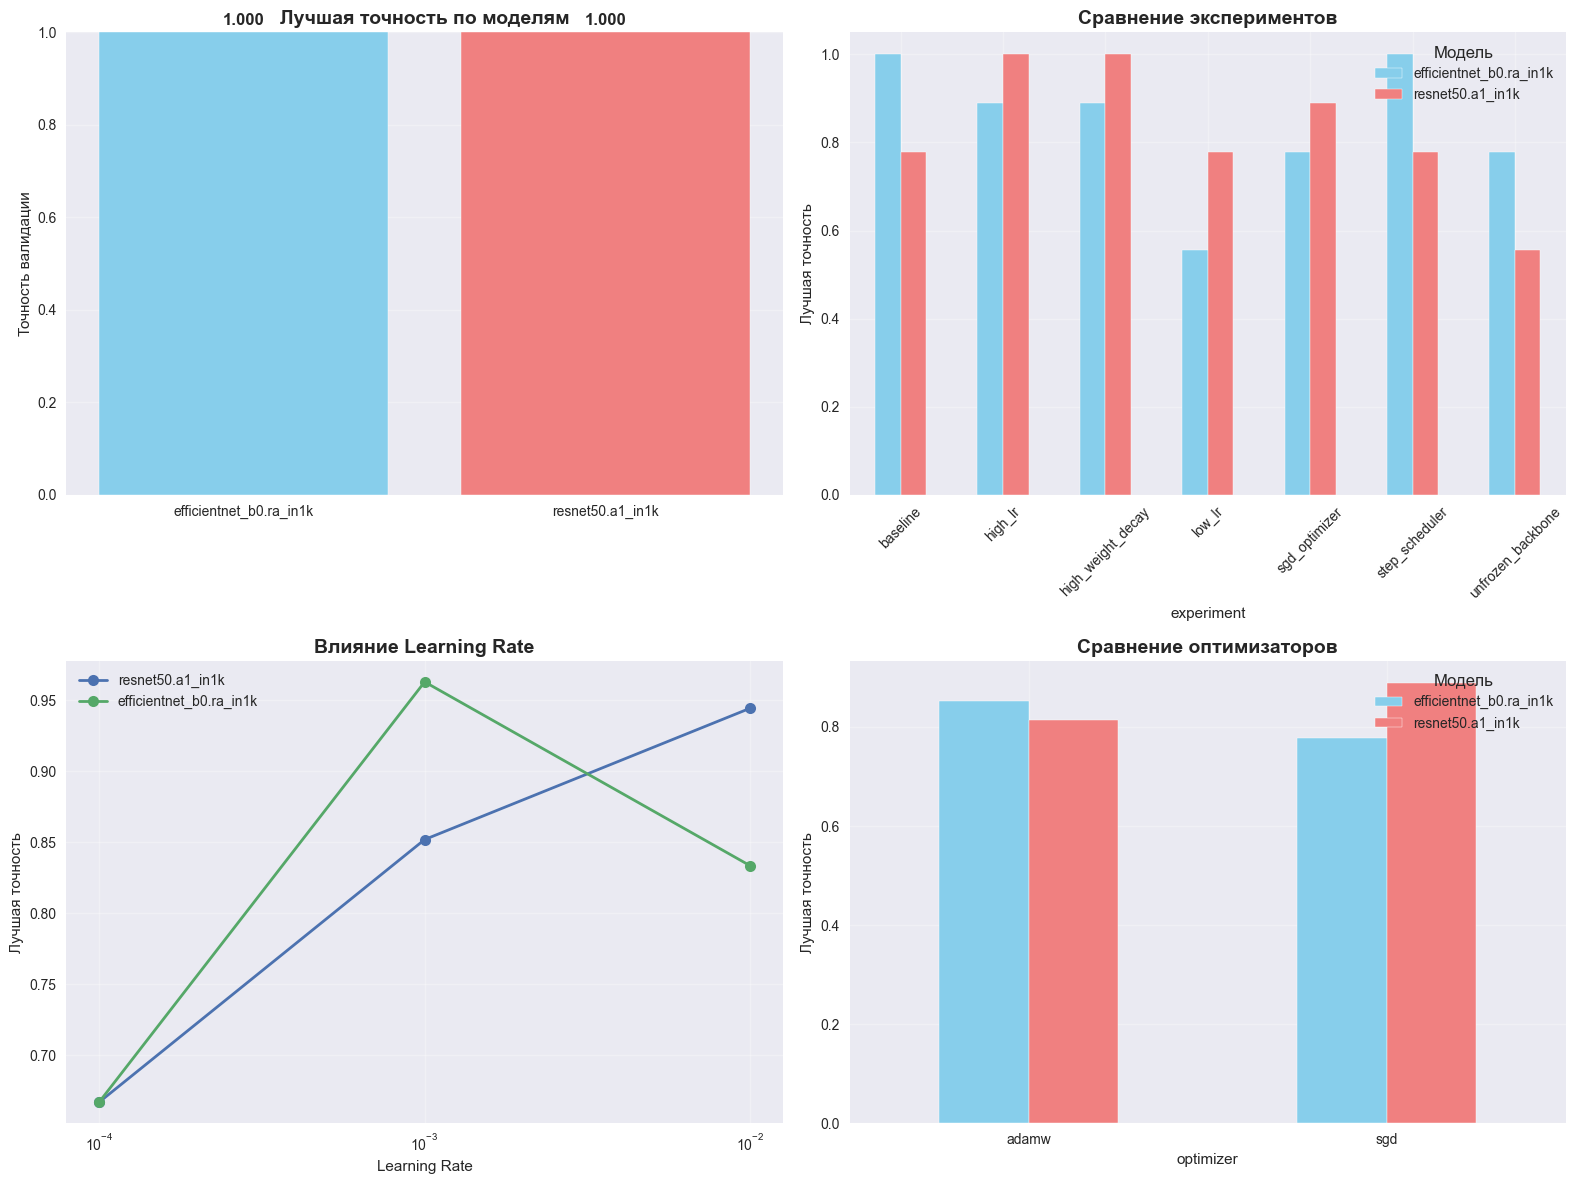

In [34]:
if results_df is not None and len(results_df) > 0:
    # Создаем графики сравнения
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Сравнение лучших точностей по моделям
    model_comparison = results_df.groupby('model')['best_val_acc'].max().reset_index()
    bars = axes[0, 0].bar(model_comparison['model'], model_comparison['best_val_acc'], 
                         color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Лучшая точность по моделям', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Точность валидации')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, v in zip(bars, model_comparison['best_val_acc']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, v + 0.01, 
                       f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Сравнение экспериментов
    pivot_table = results_df.pivot_table(index='experiment', columns='model', 
                                        values='best_val_acc', aggfunc='mean')
    pivot_table.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'lightcoral'])
    axes[0, 1].set_title('Сравнение экспериментов', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Лучшая точность')
    axes[0, 1].legend(title='Модель')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Влияние learning rate
    lr_comparison = results_df.groupby(['model', 'learning_rate'])['best_val_acc'].mean().reset_index()
    for model in results_df['model'].unique():
        model_data = lr_comparison[lr_comparison['model'] == model]
        axes[1, 0].plot(model_data['learning_rate'], model_data['best_val_acc'], 
                       marker='o', label=model, linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Learning Rate')
    axes[1, 0].set_ylabel('Лучшая точность')
    axes[1, 0].set_title('Влияние Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 0].set_xscale('log')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Сравнение оптимизаторов
    optimizer_comparison = results_df.groupby(['model', 'optimizer'])['best_val_acc'].mean().reset_index()
    optimizer_pivot = optimizer_comparison.pivot_table(index='optimizer', columns='model', 
                                                      values='best_val_acc', aggfunc='mean')
    optimizer_pivot.plot(kind='bar', ax=axes[1, 1], color=['skyblue', 'lightcoral'])
    axes[1, 1].set_title('Сравнение оптимизаторов', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Лучшая точность')
    axes[1, 1].legend(title='Модель')
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график
    comparison_plot_path = experiments_dir / "models_comparison.png"
    plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
    print(f"График сравнения сохранен в: {comparison_plot_path}")
    
    plt.show()
    
else:
    print("Нет данных для визуализации!")


## 7. Детальный анализ лучших результатов


In [36]:
if results_df is not None and len(results_df) > 0:
    # Находим лучшие результаты для каждой модели
    best_results = results_df.loc[results_df.groupby('model')['best_val_acc'].idxmax()]
    
    print("Лучшие результаты по моделям:")
    print("="*80)
    
    for _, row in best_results.iterrows():
        print(f"\nМодель: {row['model']}")
        print(f"Эксперимент: {row['experiment']}")
        print(f"Лучшая точность: {row['best_val_acc']:.4f}")
        print(f"Финальная точность: {row['final_val_acc']:.4f}")
        print(f"Финальная потеря: {row['final_val_loss']:.4f}")
        print(f"Learning Rate: {row['learning_rate']}")
        print(f"Epochs: {row['epochs']}")
        print(f"Оптимизатор: {row['optimizer']}")
        print(f"Планировщик: {row['scheduler']}")
        print(f"Замороженный backbone: {row['freeze_backbone']}")
        print("-"*40)
    
    # Статистика по моделям
    print("\nСтатистика по моделям:")
    print("="*50)
    
    model_stats = results_df.groupby('model')['best_val_acc'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    
    print(model_stats)
    
    # Статистика по экспериментам
    print("\nСтатистика по экспериментам:")
    print("="*50)
    
    exp_stats = results_df.groupby('experiment')['best_val_acc'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    
    print(exp_stats)
    
    # Сохраняем лучшие результаты
    best_results_path = experiments_dir / "best_results.csv"
    best_results.to_csv(best_results_path, index=False)
    print(f"\nЛучшие результаты сохранены в: {best_results_path}")
    
else:
    print("Нет успешных результатов для анализа!")


Лучшие результаты по моделям:

Модель: efficientnet_b0.ra_in1k
Эксперимент: baseline
Лучшая точность: 1.0000
Финальная точность: 1.0000
Финальная потеря: 0.0039
Learning Rate: 0.001
Epochs: 5
Оптимизатор: adamw
Планировщик: cosine
Замороженный backbone: True
----------------------------------------

Модель: resnet50.a1_in1k
Эксперимент: high_lr
Лучшая точность: 1.0000
Финальная точность: 1.0000
Финальная потеря: 0.3875
Learning Rate: 0.01
Epochs: 5
Оптимизатор: adamw
Планировщик: cosine
Замороженный backbone: True
----------------------------------------

Статистика по моделям:
                           mean     std     min  max  count
model                                                      
efficientnet_b0.ra_in1k  0.8413  0.1553  0.5556  1.0      7
resnet50.a1_in1k         0.8254  0.1553  0.5556  1.0      7

Статистика по экспериментам:
                     mean     std     min     max  count
experiment                                              
baseline           0.8889  0.15

## 8. Сохранение полных результатов


In [ ]:
# Сохраняем полные результаты в JSON
full_results_path = experiments_dir / "full_experiments_results.json"

# Подготавливаем данные для JSON (убираем numpy типы)
json_results = []
for result in all_results:
    json_result = result.copy()
    
    # Конвертируем numpy типы в Python типы
    if 'history' in json_result and json_result['history']:
        history = json_result['history']
        for key, values in history.items():
            if isinstance(values, list) and len(values) > 0:
                if hasattr(values[0], 'item'):  # numpy scalar
                    history[key] = [float(v.item()) if hasattr(v, 'item') else float(v) for v in values]
                elif isinstance(values[0], (np.float32, np.float64)):
                    history[key] = [float(v) for v in values]
                elif isinstance(values[0], (np.int32, np.int64)):
                    history[key] = [int(v) for v in values]
    
    # Конвертируем другие numpy типы
    for key, value in json_result.items():
        if hasattr(value, 'item'):  # numpy scalar
            json_result[key] = value.item()
        elif isinstance(value, (np.float32, np.float64)):
            json_result[key] = float(value)
        elif isinstance(value, (np.int32, np.int64)):
            json_result[key] = int(value)
    
    json_results.append(json_result)

# Сохраняем в JSON
with open(full_results_path, 'w', encoding='utf-8') as f:
    json.dump(json_results, f, indent=2, ensure_ascii=False)

print(f"Полные результаты сохранены в: {full_results_path}")

# Создаем сводный отчет
summary = {
    "experiment_date": datetime.now().isoformat(),
    "total_experiments": len(all_results),
    "successful_experiments": len(successful_results),
    "failed_experiments": len(all_results) - len(successful_results),
    "models_tested": list(set(r['model_name'] for r in all_results)),
    "experiments_tested": list(set(r['experiment_name'] for r in all_results))
}

if successful_results:
    summary["best_overall_accuracy"] = max(r['best_val_acc'] for r in successful_results)
    best_result = max(successful_results, key=lambda x: x['best_val_acc'])
    summary["best_model"] = best_result['model_name']
    summary["best_experiment"] = best_result['experiment_name']

summary_path = experiments_dir / "experiment_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"Сводный отчет сохранен в: {summary_path}")
print("\nСводка экспериментов:")
print(f"Дата: {summary['experiment_date']}")
print(f"Всего экспериментов: {summary['total_experiments']}")
print(f"Успешных: {summary['successful_experiments']}")
print(f"Неудачных: {summary['failed_experiments']}")
if 'best_overall_accuracy' in summary:
    print(f"Лучшая точность: {summary['best_overall_accuracy']:.4f}")
    print(f"Лучшая модель: {summary['best_model']}")
    print(f"Лучший эксперимент: {summary['best_experiment']}")


Полные результаты сохранены в: /Users/konopsky/University/AI_new/fine_tune/models/experiments/full_experiments_results.json
Сводный отчет сохранен в: /Users/konopsky/University/AI_new/fine_tune/models/experiments/experiment_summary.json

Сводка экспериментов:
Дата: 2025-09-27T10:40:35.437603
Всего экспериментов: 14
Успешных: 14
Неудачных: 0
Лучшая точность: 1.0000
Лучшая модель: resnet50.a1_in1k
Лучший эксперимент: high_lr
